In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9567901234567902, Loss: 0.22849061754014757
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.13606250727618183
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.10914873193811488
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.11088961142080801
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.10986027894196687


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9953797  0.00307123 0.00154909]
[0. 1. 0.] <-> [4.752119e-03 9.950830e-01 1.648805e-04]
[1. 0. 0.] <-> [0.99623424 0.00161882 0.00214691]
[1. 0. 0.] <-> [0.99718046 0.00153496 0.00128451]
[1. 0. 0.] <-> [0.9969182  0.00188612 0.00119572]
[0. 0. 1.] <-> [7.5009814e-03 9.7294505e-06 9.9248934e-01]
[1. 0. 0.] <-> [0.99537945 0.00333382 0.0012867 ]
[1. 0. 0.] <-> [0.9970897  0.0013919  0.00151852]
[0. 0. 1.] <-> [1.1800205e-02 1.5319996e-05 9.8818445e-01]
[1. 0. 0.] <-> [0.9932673  0.00534184 0.00139096]
[0. 0. 1.] <-> [7.4253385e-03 9.5544792e-06 9.9256504e-01]
[1. 0. 0.] <-> [0.9959065  0.00292355 0.00117002]
[1. 0. 0.] <-> [0.9957918  0.00302656 0.00118165]
[1. 0. 0.] <-> [0.9684559  0.00155555 0.02998852]
[1. 0. 0.] <-> [0.9968899  0.00181102 0.00129917]
[1. 0. 0.] <-> [0.9958477  0.00191116 0.0022411 ]
[1. 0. 0.] <-> [0.915243   0.08238495 0.002372  ]
[1. 0. 0.] <-> [0.9638379  0.03411423 0.0020478 ]
[1. 0. 0.] <-> [0.9937801  0.00129923 0.0049207 ]
[1. 0. 0.] <-> [0

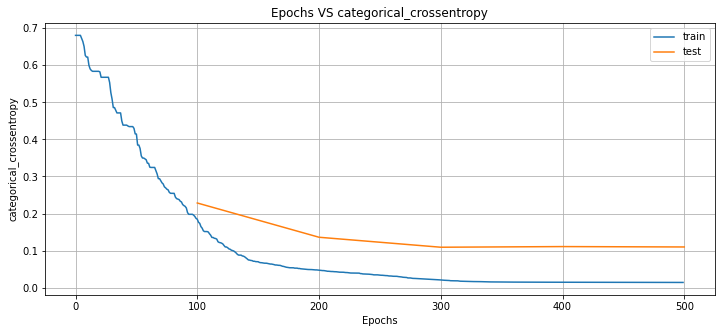

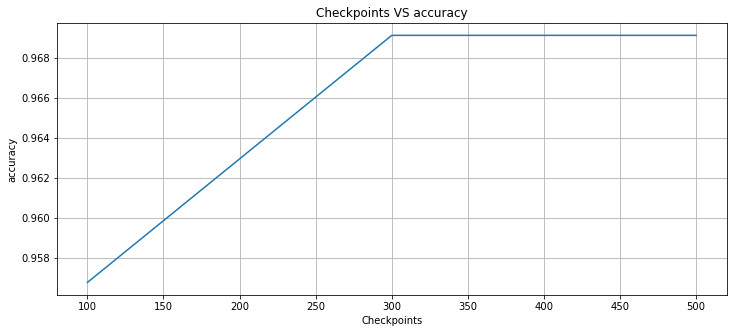

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9567901234567902, 'mean_square_error': 0.10873448333554513, 'categorical_crossentropy': 0.22849061754014757, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 6, 'tn_hit': 24, 'fn_hit': 1}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 4}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.07714384254325568, 'categorical_crossentropy': 0.13606250727618183, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 3}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.06695662944358514, 'categorical_crossentropy': 0.10914873193811488, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 2, 'tn_hit': 28, 'fn_hit': 3}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 93,

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-2.1064148   3.          3.         -2.0690906  -0.68845195]
 bias: -3.0

Neuron 1: weights:
[-0.11018545 -3.          0.06985735  1.672993    3.        ]
 bias: -2.2377336025238037

Neuron 2: weights:
[ 2.1895099 -3.        -3.        -3.         0.4318237]
 bias: 1.831145167350769

Neuron 3: weights:
[ 0.1536467  -3.         -0.48113558  0.726962    3.        ]
 bias: -2.6527304649353027

$
Layer 2
Neuron 0: weights:
[-3. -3.  3. -3.]
 bias: 0.3611569106578827

Neuron 1: weights:
[ 3. -3. -3. -3.]
 bias: -0.2946077585220337

Neuron 2: weights:
[-3.         3.        -0.7195219  3.       ]
 bias: -3.0

$

